# 04 Dimensionality reduction and peak calling
<b> Bart Theeuwes </b>

Dimensionality is first performed on the Tile Matrix in order to create clusters. Peaks are then called on these individual clusters using MACS2. These peaks are then used to create a peak matrix, on which the final dimensionality reduction is performed, the LSI and UMAP dimensions of which will be used in the rest of the analysis.

In [1]:
source(here::here("settings.R"))
source(here::here("load_archr.R"))

# I/O
io$output.directory <- file.path(io$basedir,"ArchR")
setwd(io$output.directory)

Setting default number of Parallel threads to 1.

Setting addArchRVerbose = FALSE

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\__

#### Run dimensionality reduction on TileMatrix

In [2]:
addArchRThreads(threads = 30) 

Setting default number of Parallel threads to 30.



In [3]:
# Run dimensionality reduction on TileMatrix
ArchRProject = dim_redu(matrix = 'TileMatrix', 
         nfeatures = 60000, 
         batch.variable = NULL,
         ndims = 45, 
         n_neighbors = 35,
         min_dist = 0.3, 
         colour_by = c("sample","stage", "DoubletEnrichment", "nFrags", "TSSEnrichment"),
         final_run = TRUE
    )

Checking Inputs...

Warning message:
“package ‘Seurat’ was built under R version 4.1.2”
Overriding previous entry for Clusters_TileMatrix

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 34082
Number of edges: 1464476

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9180
Number of communities: 28
Elapsed time: 5 seconds


1 singletons identified. 27 final clusters.

Warning message in .local(x, row.names, optional, ...):
“Arguments in '...' ignored”
21:20:24 UMAP embedding parameters a = 0.9922 b = 1.112

21:20:24 Read 34082 rows and found 45 numeric columns

21:20:24 Using Annoy for neighbor search, n_neighbors = 35

21:20:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:20:28 Writing NN index file to temp file /tmp/RtmpZ7E0x1/file1a8ef6febbf4

21:20:28 Searching Annoy index using 16 threads, search_k = 3500

21:20:30 Annoy recall = 100%

21:20:32 Commencing smooth kNN distance calibration using 16 threads

21:20:35 Initializing from normalized Laplacian + noise

21:20:38 Commencing optimization for 200 epochs, with 1935992 positive edges

21:21:24 Optimization finished

Scale for

#### Peak calling on TileMatrix clusters

In [4]:
# Define arguments for peak calling
args = list()
args$group_by = 'Clusters_TileMatrix'
args$pathToMacs2 = findMacs2()
args$pvalue_cutoff = 0.001
args$extend_summits = 250
args$outdir = file.path(io$base, 'ArchR/Peak_calling')

dir.create(args$outdir, showWarnings = FALSE)

Searching For MACS2..

Found with $path!



In [5]:
addArchRThreads(threads = 1) 

Setting default number of Parallel threads to 1.



In [6]:
# Add Group Coverages
ArchRProject <- addGroupCoverages(ArchRProject, 
  groupBy = args$group_by,
  useLabels = TRUE,
  force = TRUE
)

saveArchRProject(ArchRProject)

chr1 
chr10 
chr11 
chr12 
chr13 
chr14 
chr15 
chr16 
chr17 
chr18 
chr19 
chr2 
chr20 
chr4 
chr5 
chr6 
chr7 
chr8 
chr9 
chrX 
Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
 

class: ArchRProject 
outputDirectory: /rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project 
samples(8): rabbit_BGRGP1 rabbit_BGRGP2 ... rabbit_BGRGP7 rabbit_BGRGP8
sampleColData names(1): ArrowFiles
cellColData names(18): Sample TSSEnrichment ... ReadsInPeaks FRIP
numberOfCells(1): 34082
medianTSS(1): 3.615
medianFrags(1): 33602

In [7]:
# Call peaks
ArchRProject <- addReproduciblePeakSet(
  ArchRProj = ArchRProject, 
  groupBy = args$group_by, 
  peakMethod = "Macs2",
  excludeChr = c("chrM", "chrY"),
  pathToMacs2 = args$pathToMacs2,
  genomeSize = 2.7e9, # This argument is needed for the non-standard genome
  cutOff = args$pvalue_cutoff,
  extendSummits = args$extend_summits,
  plot = FALSE,
  force = TRUE
)

# Save
saveArchRProject(ArchRProject)
# fetch peaks in data.table format
dt <- getPeakSet(ArchRProject) %>% as.data.table() %>% setnames("seqnames","chr")
# Save peak metadata
fwrite(dt, file.path(args$outdir,"peak_metadata.tsv.gz"), sep="\t")
# save peaks in bed format
fwrite(dt[,c("chr","start","end")], file.path(args$outdir,"peaks_archR_macs2.bed.gz"), sep="\t", col.names = F)

    Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
C1     C1    532        500           2  239  261   150000
C2     C2    120        120           2   40   80    60000
C3     C3    508        508           2   40  468   150000
C4     C4    225        225           2   40  185   112500
C5     C5   1342       1000           2  500  500   150000
C6     C6     35         35           2   23   25    17500
C7     C7    106        106           2   40   66    53000
C8     C8   2989        540           2   40  500   150000
C9     C9    917        900           3  196  373   150000
C10   C10   1017        717           3   43  500   150000
C11   C11    808        680           5   93  173   150000
C12   C12    592        559           2  257  302   150000
C13   C13   1996        540           2   40  500   150000
C14   C14   2878        540           2   40  500   150000
C15   C15   1865       1385           5  120  500   150000
C16   C16   1156       1000           2  500  500   1500

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C1-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C10-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C11-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C12-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C13-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C14-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C15-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C16-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C17-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C18-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C19-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C2-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C20-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C21-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C22-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C23-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C24-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C25-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C3-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C4-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C5-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C6-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C7-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C8-reproduciblePeaks.gr.rds"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 3 out-of-bound ranges located on sequences
  chr12, chr13, and chr16. Note that ranges located on a sequence whose
  length is unknown (NA) or on a circular sequence are not considered
  out-of-bound (use seqlengths() and isCircular() to get the lengths and
  circularity flags of the underlying sequences). You can use trim() to
  trim these ranges. See ?`trim,GenomicRanges-method` for more
  in

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project/PeakCalls/C9-reproduciblePeaks.gr.rds"


Converged after 11 iterations!

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\____

class: ArchRProject 
outputDirectory: /rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project 
samples(8): rabbit_BGRGP1 rabbit_BGRGP2 ... rabbit_BGRGP7 rabbit_BGRGP8
sampleColData names(1): ArrowFiles
cellColData names(18): Sample TSSEnrichment ... ReadsInPeaks FRIP
numberOfCells(1): 34082
medianTSS(1): 3.615
medianFrags(1): 33602

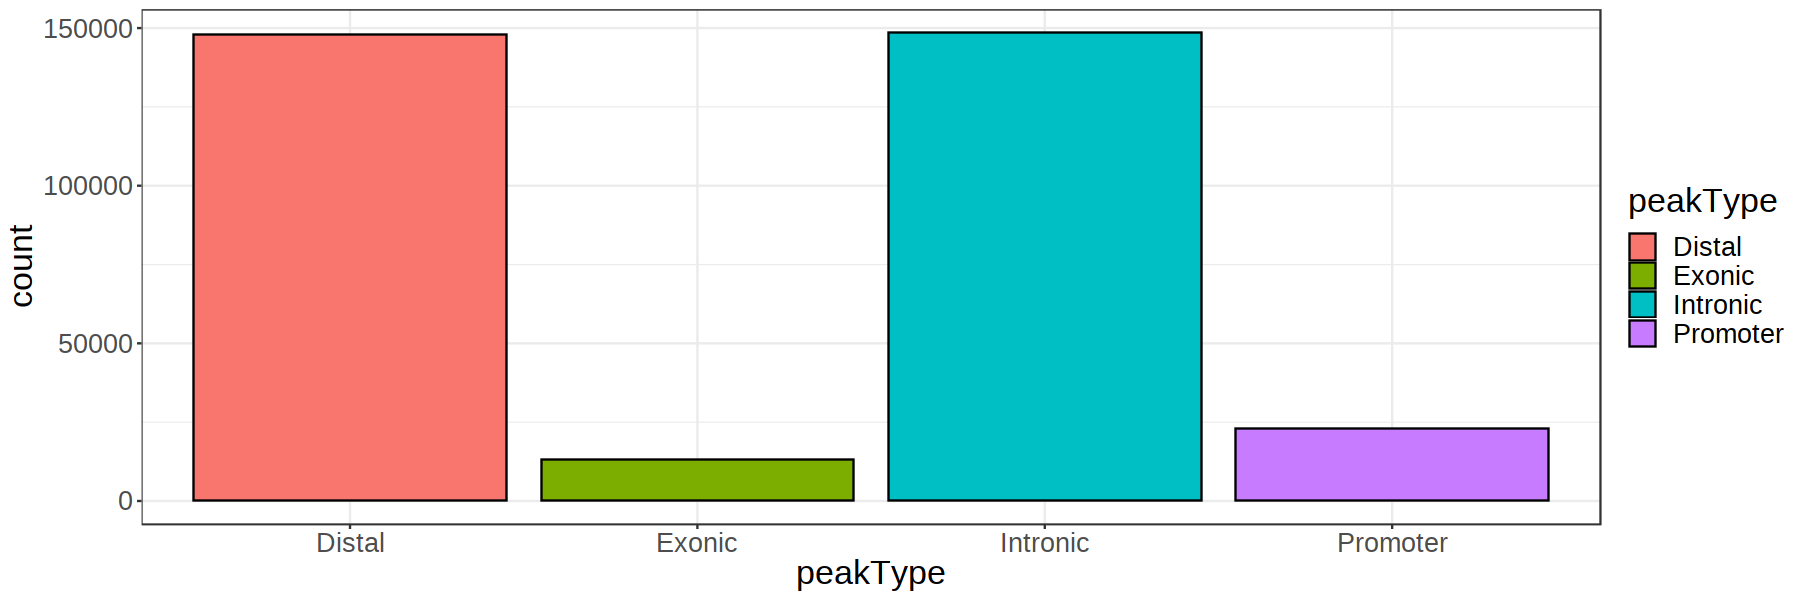

In [8]:
plot = ggplot(as.data.table(getPeakSet(ArchRProject)), aes(peakType,fill=peakType)) + geom_bar(col='black') + theme_bw() + theme(text=element_text(size=20))
plot
# Turn into suppl figure?

In [9]:
plot = ggplot(as.data.table(getPeakSet(ArchRProject)), aes(peakType,fill=peakType, col='black')) + geom_bar() + theme_bw() + theme(text=element_text(size=20))
# Turn into suppl figure?

In [ ]:
# Create PeakMatrix
ArchRProject <- addPeakMatrix(ArchRProject)
# Save
saveArchRProject(ArchRProject)

#### Run dimensionality reduction on PeakMatrix

In [ ]:
addArchRThreads(threads = 30) 

In [ ]:
# Run dimensionality reduction
ArchRProject = dim_redu(matrix = 'PeakMatrix', 
         nfeatures = 60000, 
         batch.variable = NULL,
         ndims = 45, 
         n_neighbors = 45,
         min_dist = 0.5, 
         colour_by = c("sample","stage", "DoubletEnrichment", "nFrags", "Clusters_TileMatrix", "Clusters_PeakMatrix", "TSSEnrichment"),
         final_run = TRUE
    )

#### Calculate imputation weights

In [ ]:
ArchRProject = addImputeWeights(
  ArchRProj = ArchRProject,
  reducedDims = "PeakMatrix")

In [ ]:
saveArchRProject(ArchRProject)